In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3
import pandas as pd


# company 데이터 다운로드
company = pd.read_excel('/content/drive/Shareddrives/데이터마이닝 2023-2/datamining_dataset_final.xlsx')
df = pd.read_excel('/content/drive/MyDrive/check.xlsx')

# SQLite 데이터베이스 연결
conn = sqlite3.connect(':memory:')  # 메모리에 데이터베이스 생성

# 데이터프레임을 SQLite 테이블로 저장
company.to_sql('company', conn, index=False)
df.to_sql('cluster', conn, index=False)

# SQL 쿼리 작성
sql_query = """
  SELECT DISTINCT c.company, cl1.'check' AS cluster1, cl2.'check' AS cluster2, cl3.'check' AS cluster3, cl4.'check' AS cluster4, cl5.'check' AS cluster5
  FROM company c
  LEFT JOIN cluster cl1 ON c.colors1 = cl1.Colors
  LEFT JOIN cluster cl2 ON c.colors2 = cl2.Colors
  LEFT JOIN cluster cl3 ON c.colors3 = cl3.Colors
  LEFT JOIN cluster cl4 ON c.colors4 = cl4.Colors
  LEFT JOIN cluster cl5 ON c.colors5 = cl5.Colors;

"""

# SQL 쿼리 실행
result= pd.read_sql_query(sql_query, conn)

# 클러스터 번호를 이름으로 매핑하는 딕셔너리 생성
cluster_mapping = {
    0: 'Green',
    1: 'Red',
    2: 'White',
    3: 'Skyblue',
    4: 'Black',
    5 : 'Orange',
    6: 'Gray',
    7: 'Blue',
}

# 각 클러스터 열에 대해 매핑 적용
for i in range(1, 6):  # 클러스터 열은 cluster1부터 cluster5까지 있음
    column_name = f'cluster{i}'
    result[column_name] = result[column_name].map(cluster_mapping)

# 연결 종료
conn.close()

# 결과 확인
print(result)

                                        company cluster1 cluster2 cluster3  \
0                            Berkshire Hathaway     Blue      NaN      NaN   
1                                          ICBC    Black      Red      NaN   
2      Saudi Arabian Oil Company (Saudi Aramco)    White  Skyblue    Green   
3                                JPMorgan Chase     Blue    White      NaN   
4                       China Construction Bank     Blue    Black      NaN   
...                                         ...      ...      ...      ...   
1994                                     Aperam    Black     Gray   Orange   
1995  Shenzhen Feima International Supply Chain    Green      Red      NaN   
1996                                       NMDC     Blue      NaN      NaN   
1997                 Sichuan Changhong Electric      Red      NaN      NaN   
1998                         Satellite Chemical     Blue      Red      NaN   

     cluster4 cluster5  
0         NaN      NaN  
1         NaN

In [ ]:
result_df = pd.DataFrame(result)

# 새로운 데이터 구조로 변환
new_data = {'Company': [], 'Colors': []}

for _, row in result_df.iterrows():
    company = row['company']
    clusters = [row[f'cluster{i}'] for i in range(1, 6) if pd.notna(row[f'cluster{i}'])]
    new_data['Company'].append(company)
    new_data['Colors'].append(clusters)

# 새로운 데이터프레임 생성
new_df = pd.DataFrame(new_data)

classification = pd.read_excel('/content/drive/MyDrive/Forbes_2000_top_company.xlsx')

new_df['Industry'] = classification['Industry']

# 결과 출력
print(new_df)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                        Company  \
0                            Berkshire Hathaway   
1                                          ICBC   
2      Saudi Arabian Oil Company (Saudi Aramco)   
3                                JPMorgan Chase   
4                       China Construction Bank   
...                                         ...   
1994                                     Aperam   
1995  Shenzhen Feima International Supply Chain   
1996                                       NMDC   
1997                 Sichuan Changhong Electric   
1998                         Satellite Chemical   

                              Colors                      Industry  
0                             [Blue]        Diversified Financials  
1                       [Black, Red]                       Banking  
2     [White, Skyblue, Green, Green]          Oil & Gas Operations  
3                      [Blue, White]        Diversified Financials  
4                      [Blue, Black]      

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 데이터프레임을 transactions로 변환
transactions = new_df['Colors'].explode().groupby(new_df['Company']).apply(list).tolist()

# TransactionEncoder를 사용하여 트랜잭션 데이터를 one-hot 인코딩
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori 알고리즘을 사용하여 빈발 아이템셋 찾기
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

# 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

# 결과 출력
print(rules)

  antecedents consequents  antecedent support  consequent support  support  \
0     (Black)       (Red)            0.336168            0.384192  0.13957   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.415179  1.080654  0.010417    1.052985       0.112429  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Assuming new_df is the original DataFrame with 'Industry' column
# and 'Colors' column containing the color information

# 선택하려는 분야 리스트
selected_industries = ['Banking', 'Construction', 'Diversified Financials', 'Insurance', 'Materials', 'Oil & Gas Operations']

# 필터링된 DataFrame 생성
filtered_df = new_df[new_df['Industry'].isin(selected_industries)].copy()

# 분야에 따라 그룹화하여 회사 목록을 수집
grouped_companies = filtered_df.groupby('Industry').apply(lambda x: {'Company': x['Company'].tolist(), 'Colors': x['Colors'].tolist()}).reset_index()

# 각 그룹을 따로 저장하고 연관 규칙 생성
for index, group in grouped_companies.iterrows():
    field = group['Industry']
    companies = group[0]['Company']
    colors = group[0]['Colors']
    group_df = pd.DataFrame({'Company': companies, 'Colors': colors})

    # 데이터프레임을 transactions로 변환
    transactions = group_df['Colors'].explode().groupby(group_df['Company']).apply(list).tolist()

    # TransactionEncoder를 사용하여 트랜잭션 데이터를 one-hot 인코딩
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Apriori 알고리즘을 사용하여 빈발 아이템셋 찾기
    frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

    # 연관 규칙 생성
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

    # 결과 출력
    print(f'{field}_association_rules : ')
    print(rules)
    print('\n\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Banking_association_rules : 
  antecedents consequents  antecedent support  consequent support   support  \
0    (Orange)     (Black)            0.280277            0.370242  0.114187   
1       (Red)     (Black)            0.439446            0.370242  0.183391   
2     (Black)       (Red)            0.370242            0.439446  0.183391   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.407407  1.100381  0.010417    1.062716       0.126748  
1    0.417323  1.127162  0.020689    1.080801       0.201258  
2    0.495327  1.127162  0.020689    1.110727       0.179142  



Construction_association_rules : 
  antecedents consequents  antecedent support  consequent support  support  \
0       (Red)     (Black)            0.472441            0.377953  0.23622   
1     (Black)       (Red)            0.377953            0.472441  0.23622   

   confidence      lift  leverage  conviction  zhangs_metric  
0       0.500  1.322917   0.05766    1.244094       0.462687  
1   

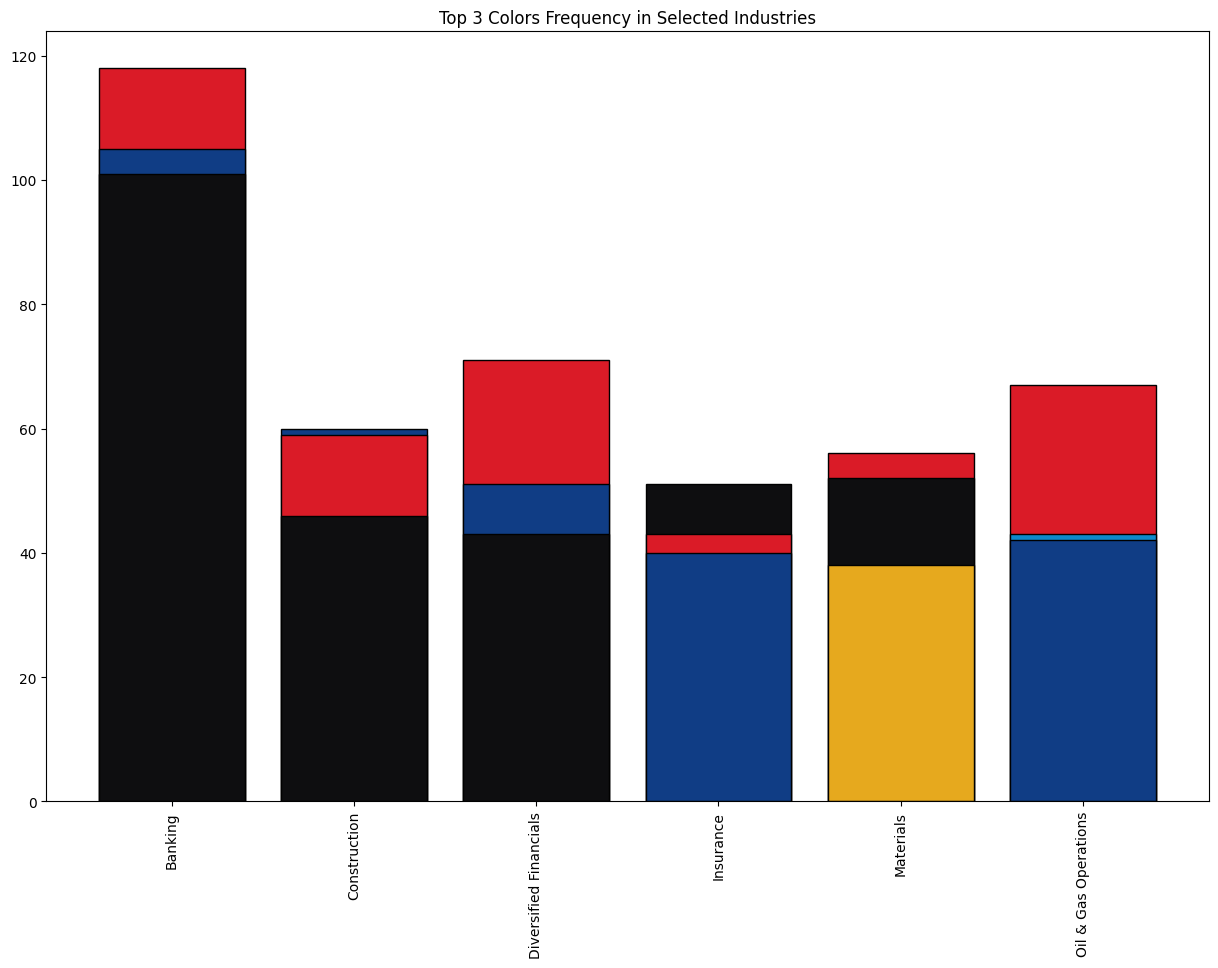

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to parse the color strings into RGB tuples
def parse_color(color_str):
    # Strip the brackets and split the string by space, then create a tuple of floats
    return tuple(map(float, color_str.strip('[]').split()))

# Load your data
df = pd.read_excel('/content/drive/Shareddrives/데이터마이닝 2023-2/김수현/8_clustering_data.xlsx', engine='openpyxl')
# Convert the color columns
for col in ['colors1', 'colors2', 'colors3', 'colors4', 'colors5']:
    df[col] = df[col].dropna().apply(parse_color)

# Convert the lists in the 'color' column to tuples
df_melted['color'] = df_melted['color'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Now calculate the color frequency for each industry
color_counts = df_melted.groupby(['Industry', 'color']).size().reset_index(name='count')

# Then find the top 3 colors for each industry
top_colors = color_counts.groupby('Industry').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)


# Select industries of interest
selected_industries = ['Banking', 'Construction', 'Diversified Financials', 'Insurance', 'Materials', 'Oil & Gas Operations']

# Filter the top colors for the selected industries
top_colors_filtered = top_colors[top_colors['Industry'].isin(selected_industries)]

# Create a palette that maps color tuples to their corresponding RGB values divided by 255
palette = {color: tuple(component/255 for component in color) for color in top_colors['color'].unique()}

# Plotting the bar graph with black borders
plt.figure(figsize=(15, 10))
for _, row in top_colors_filtered.iterrows():
    plt.bar(row['Industry'], row['count'], color=palette[row['color']], edgecolor='black')

plt.xticks(rotation=90)
plt.title('Top 3 Colors Frequency in Selected Industries')
plt.show()